In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

%matplotlib inline 

In [2]:
import Tools.FNC as cf

#### The probabilites probabilities of the each row was calculated in notebook 03. Here the probability was combined with the rest of the data and more features will be created.

In [3]:
#import the dataframes and target

df = pd.read_csv('./Data/restaurant_data')
target_df = pd.read_csv('./Data/target_data')
proba = pd.read_csv('./Data/all_proba')

#merge the data with the target
restaurants_df = df.merge(target_df,
                         how = 'inner',
                         left_on = ['Unnamed: 0'],
                         right_on = ['Unnamed: 0']
                         )

#create a copy for use later
rest_df = restaurants_df.copy()

#merge the copy with the probabilies
rest_proba_df = rest_df.merge(proba,
                              how = 'inner',
                              left_on = ['Unnamed: 0'],
                              right_on = ['Unnamed: 0'])

In [4]:
#drop the unnamed column
rest_proba_df.drop('Unnamed: 0' , axis=1,inplace =True)

In [5]:
#set the original data to the combined data
restaurants_df = rest_proba_df

In [6]:
restaurants_df.head()

,user_id,prod_id,rating,date,review,name,target,0,1
0,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1,0.525403,0.474597
1,7175,287,3.0,2013-10-30,This place is always busy - partly because it'...,Heidi’s House,1,0.361704,0.638296
2,137409,744,5.0,2014-12-04,Love this place! I am not a regular yelper I d...,Bodhi Tree,0,0.308041,0.691959
3,62647,625,5.0,2013-02-25,After extensive yelping to find a great place ...,Perilla,1,0.470336,0.529664
4,6080,307,5.0,2014-09-20,Very tasty indian food that is a bit different...,Pippali,1,0.519505,0.480495


In [7]:
#create a new copy of the dataframe which will not remove the columns
r_df = restaurants_df.copy()

In [8]:
#remove unnecessary
restaurants_df.drop(['user_id','prod_id','date','rating','name'],axis = 1 ,inplace = True)

#### The sample of the probability is shown here. These probabilities are obtained from the previous models which determine the truth based solely on NLP.

In [9]:
restaurants_df.head()

,review,target,0,1
0,I had waited to return a couple other times to...,1,0.525403,0.474597
1,This place is always busy - partly because it'...,1,0.361704,0.638296
2,Love this place! I am not a regular yelper I d...,0,0.308041,0.691959
3,After extensive yelping to find a great place ...,1,0.470336,0.529664
4,Very tasty indian food that is a bit different...,1,0.519505,0.480495


In [10]:
#lower-case the reviews
restaurants_df['review'] = restaurants_df['review'].str.lower()

In [12]:
#tokenize the restaurant reviews
restaurants_df['review_tokenized'] = restaurants_df['review'].apply(cf.tokenize_text)

In [13]:
#create stopwords and added the common words
sw = stopwords.words("english")
sw += ['food','place','good',"great"]
restaurants_df['review_tokenized'] = restaurants_df['review_tokenized'].apply(lambda x: [item for item in x if item not in sw])

In [14]:
restaurants_df2 = restaurants_df.copy()

In [15]:
restaurants_df2.drop('review',axis = 1,inplace = True)

#### The data is split to truth and fake to take a closer look at our target

In [16]:
t_words = restaurants_df2[restaurants_df2['target'] == 1]
t_words.head()

,target,0,1,review_tokenized
0,1,0.525403,0.474597,"[waited, return, couple, times, give, assessme..."
1,1,0.361704,0.638296,"[always, busy, partly, tiny, nonethless, call,..."
3,1,0.470336,0.529664,"[extensive, yelping, find, boyfriends, birthda..."
4,1,0.519505,0.480495,"[tasty, indian, bit, different, rest, menu, it..."
5,1,0.514153,0.485847,"[visited, woorijip, lunch, recent, afternoon, ..."


In [17]:
exp_t_words = t_words.explode('review_tokenized')

In [18]:
top_positive_words  = exp_t_words.groupby('review_tokenized')['target'].count().sort_values(ascending = False)

In [19]:
f_words = restaurants_df2[restaurants_df2['target'] == 0]
f_words.head()

,target,0,1,review_tokenized
2,0,0.308041,0.691959,"[love, regular, yelper, dont, write, review, m..."
8,0,0.501025,0.498975,"[filipino, dont, expect, pay, meal, mom, know,..."
12,0,0.598785,0.401215,"[best, grilled, cheese, sandwiches, world, alw..."
15,0,0.621884,0.378116,"[hands, favorite, park, slope, haunt, fun, bar..."
16,0,0.445621,0.554379,"[fave, brooklyn, bar, packed, id, come, often,..."


In [20]:
exp_f_words = f_words.explode('review_tokenized')

#### With the most common words removed, the top words are slightly different from one another.

In [21]:
top_false_words  = exp_f_words.groupby('review_tokenized')['target'].count().sort_values(ascending = False)
top_false_words.iloc[4:,].head(20)

review_tokenized
really        5275
back          5129
get           5127
time          5114
restaurant    5055
best          4980
would         4559
delicious     4430
pizza         4167
love          4142
us            4057
wait          3837
also          3662
dont          3494
amazing       3471
nice          3446
staff         3270
menu          3154
even          3034
try           3025
Name: target, dtype: int64

In [22]:
top_positive_words[4:,].head(20)

review_tokenized
back          60209
go            59774
service       59361
time          58272
delicious     56139
would         56038
also          55667
best          46904
wait          46757
restaurant    45304
dont          45057
ordered       44676
got           44191
sauce         43842
us            42481
chicken       42325
ive           42140
menu          41860
little        41316
well          41119
Name: target, dtype: int64

In [23]:
r_df['year']= r_df["date"].astype(str).str[0:4]

#### Here we create a new feature for the number of reviews done by user

In [32]:
ct_df = r_df.groupby('user_id')['year'].count()

In [33]:
ct_df = ct_df.to_frame()

In [34]:
ct_df = ct_df.rename({'year':'rev_count'},axis = 1)
ct_df.head()

,rev_count
user_id,
923,28
925,2
926,1
927,4
928,1


In [35]:
r_df.head()

,user_id,prod_id,rating,date,review,name,target,0,1,year
0,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1,0.525403,0.474597,2013
1,7175,287,3.0,2013-10-30,This place is always busy - partly because it'...,Heidi’s House,1,0.361704,0.638296,2013
2,137409,744,5.0,2014-12-04,Love this place! I am not a regular yelper I d...,Bodhi Tree,0,0.308041,0.691959,2014
3,62647,625,5.0,2013-02-25,After extensive yelping to find a great place ...,Perilla,1,0.470336,0.529664,2013
4,6080,307,5.0,2014-09-20,Very tasty indian food that is a bit different...,Pippali,1,0.519505,0.480495,2014


#### Using the account_length function, each user is asligned with the age of their account based on their first and last post

In [36]:
u,yr = cf.account_length(r_df)

#### The two lists are are turned to dataframes and joined for analysis

In [37]:
user_list_df = pd.DataFrame(u, columns = ['users'])

In [38]:
act_length_df = pd.DataFrame(yr, columns = ['act_len'])

In [39]:
user_act_length_df = user_list_df.join(act_length_df)

In [40]:
user_info_df = user_act_length_df.merge(ct_df, left_on='users', right_on = 'user_id')
user_info_df.head()

,users,act_len,rev_count
0,923,1,28
1,925,0,2
2,926,0,1
3,927,0,4
4,928,0,1


#### A new dataset is created to include the account length and number of reviews. The review is tokenized with a new column.

In [41]:
Restaurants_w_features_df = pd.merge(r_df,user_info_df,how='outer' ,left_on = "user_id",right_on = 'users')
Restaurants_w_features_df.head()

,user_id,prod_id,rating,date,review,name,target,0,1,year,users,act_len,rev_count
0,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1,0.525403,0.474597,2013,19590.0,2.0,15.0
1,19590,347,5.0,2014-05-15,"Named after the port of Tunis, the Tunisian ca...",La Goulette,1,0.203969,0.796031,2014,19590.0,2.0,15.0
2,19590,654,5.0,2012-05-27,This is my third time coming here and i am onc...,Go! Go! Curry!,1,0.478470,0.521530,2012,19590.0,2.0,15.0
3,19590,228,4.0,2014-01-01,A dive bar! I didn't have any expectations up...,The Levee,1,0.489924,0.510076,2014,19590.0,2.0,15.0
4,19590,676,5.0,2012-12-14,I visited this Shack which opened not very lon...,Shake Shack,1,0.596447,0.403553,2012,19590.0,2.0,15.0


In [42]:
Restaurants_w_features_df['review_tokenized'] = Restaurants_w_features_df['review'].apply(cf.tokenize_text)

In [43]:
Restaurants_w_features_df.head()

,user_id,prod_id,rating,date,review,name,target,0,1,year,users,act_len,rev_count,review_tokenized
0,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1,0.525403,0.474597,2013,19590.0,2.0,15.0,"[i, had, waited, to, return, a, couple, other,..."
1,19590,347,5.0,2014-05-15,"Named after the port of Tunis, the Tunisian ca...",La Goulette,1,0.203969,0.796031,2014,19590.0,2.0,15.0,"[named, after, the, port, of, tunis, the, tuni..."
2,19590,654,5.0,2012-05-27,This is my third time coming here and i am onc...,Go! Go! Curry!,1,0.478470,0.521530,2012,19590.0,2.0,15.0,"[this, is, my, third, time, coming, here, and,..."
3,19590,228,4.0,2014-01-01,A dive bar! I didn't have any expectations up...,The Levee,1,0.489924,0.510076,2014,19590.0,2.0,15.0,"[a, dive, bar, i, didnt, have, any, expectatio..."
4,19590,676,5.0,2012-12-14,I visited this Shack which opened not very lon...,Shake Shack,1,0.596447,0.403553,2012,19590.0,2.0,15.0,"[i, visited, this, shack, which, opened, not, ..."


#### Since the probability of 0 and 1 is directly correlated with oneanother, the probability of 0 was removed along with other features that are not used for analysis.

In [44]:
rest_w_feat_df = Restaurants_w_features_df.drop(['user_id','prod_id','date','review','name','0','users','review_tokenized','year'],axis = 1)

In [45]:
rest_w_feat_df.dropna(inplace = True)

In [46]:
rest_w_feat_df.head()

,rating,target,1,act_len,rev_count
0,5.0,1,0.474597,2.0,15.0
1,5.0,1,0.796031,2.0,15.0
2,5.0,1,0.521530,2.0,15.0
3,4.0,1,0.510076,2.0,15.0
4,5.0,1,0.403553,2.0,15.0


#### Here the data is sepereated between the one used for analysis and target. A test train split is performed to see how well our model preforms.

In [47]:
Feat = rest_w_feat_df.drop('target',axis = 1)
target = rest_w_feat_df.target

In [48]:
X_train,X_test,y_train,y_test = train_test_split(Feat,
                                                 target,
                                                 stratify = target,
                                                 random_state = 42)

# Logistic Regression Model

In [50]:
clf = LogisticRegression()

Train score 0.8976118005151018


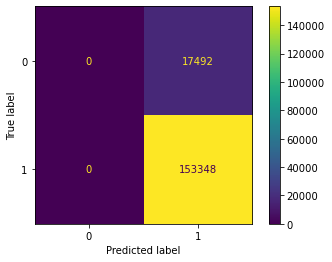

In [51]:
cf.score(clf, X= X_train, y= y_train)

Test score 0.8976065464379159


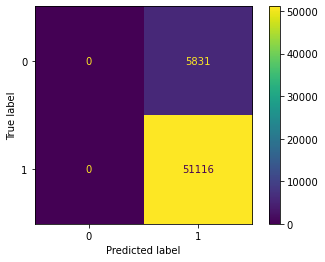

In [52]:
cf.score(clf,X = X_test, y = y_test, text = 'Test')

# Logistic Regression Model with Smote

In [59]:
clf_smote =Pipeline([
       ('smote', SMOTE(random_state=42)),
       ('clf', clf)])

Train score 0.5272594240224772


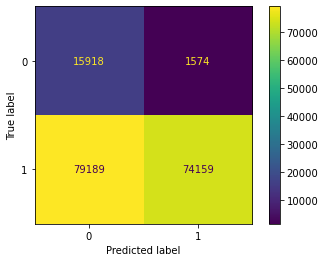

In [60]:
cf.score(clf_smote,X = X_train, y = y_train)

Test score 0.5355330394928618


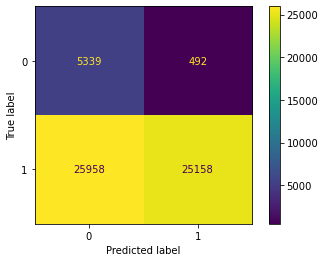

In [61]:
cf.score(clf_smote,X = X_test, y = y_test, text = 'Test')

# Random Forest Model

In [67]:
rf_pipe =Pipeline([
       ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

Train score 0.8976118005151018


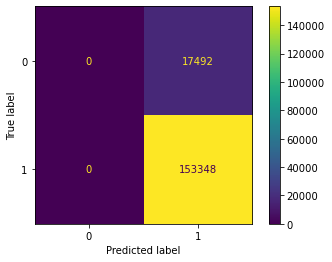

In [68]:
cf.score(rf_pipe,X= X_train, y= y_train)

Test score 0.8976065464379159


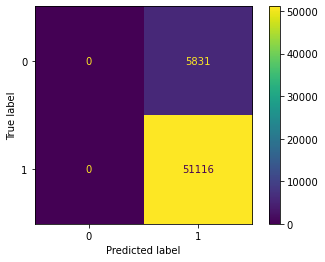

In [69]:
cf.score(rf_pipe,X = X_test, y = y_test, text = 'Test')

# Random Forest with Smote

In [73]:
rf_sm =Pipeline([
       ('smote', SMOTE(random_state=42)),
       ('rf', RandomForestClassifier(max_depth=2, random_state=0))])

Train score 0.6051861390774994


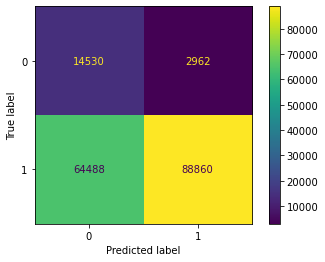

In [74]:
cf.score(rf_sm,X= X_train, y= y_train)

Test score 0.6107433227386868


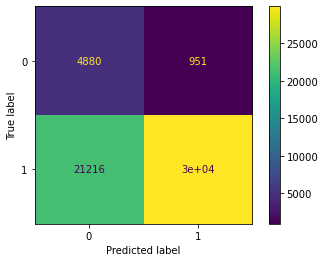

In [75]:
cf.score(rf_sm,X = X_test, y = y_test, text = 'Test')

# Naive Bayes with Smote

In [80]:
text_nb =Pipeline([
       ('smote', SMOTE(random_state=42)),
       ('nb', naive_bayes.MultinomialNB())])

Train score 0.5221727932568485


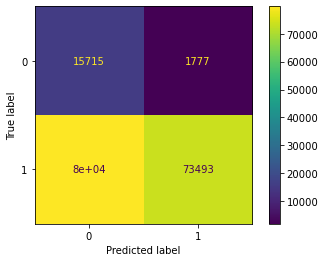

In [81]:
cf.score(text_nb,X= X_train, y= y_train)

Test score 0.5301420619172212


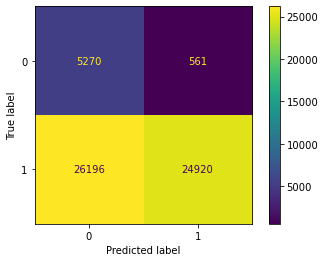

In [82]:
cf.score(text_nb,X = X_test, y = y_test, text = 'Test')